<a href="https://colab.research.google.com/github/elemnurguner/data-ai-projects/blob/main/AIDestekliTrafik%C4%B0%C5%9FaretiTan%C4%B1ma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trafik İşareti Tanıma Sistemi - Proje Analizi 🚦
1. Proje Amacı
Otonom araçlar ve akıllı ulaşım sistemleri için kritik bir bileşen olan trafik işareti tanıma sistemleri geliştirmek. Görüntü işleme ve derin öğrenme teknikleriyle 43 farklı trafik işaretini sınıflandıran bir AI modeli oluşturmak.

2. Kullanılan Teknolojiler
Teknoloji	Açıklama
Python	Programlama Dili
TensorFlow/Keras	Derin Öğrenme Kütüphanesi
OpenCV	Görüntü İşleme
Scikit-learn	Veri Bölme & Ön İşleme
Matplotlib	Görselleştirme

3. Veri Seti (GTSRB)
Kaynak: Alman Trafik İşaretleri Benchmark Veri Seti

İstatistikler:

43 farklı sınıf

39,209 eğitim görüntüsü

12,630 test görüntüsü

Değişken boyutlar (15x15 - 250x250 piksel)

In [ ]:
# GTSRB veri setini Colab'a indirme
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

# ZIP dosyalarını açma
!unzip GTSRB_Final_Training_Images.zip
!unzip GTSRB_Final_Test_Images.zip

In [6]:
import os

# Veri setinin yolunu belirleme
data_dir = '/content/GTSRB/Final_Training/Images'

# Klasörlerin (sınıfların) sayısını kontrol etme
num_classes = len(os.listdir(data_dir))
print(f"Toplam sınıf sayısı: {num_classes}")

# Örnek bir klasördeki görüntü sayısını kontrol etme
sample_class = os.listdir(data_dir)[0]
sample_class_dir = os.path.join(data_dir, sample_class)
num_images_in_sample_class = len(os.listdir(sample_class_dir))
print(f"Örnek klasördeki görüntü sayısı: {num_images_in_sample_class}")

Toplam sınıf sayısı: 43
Örnek klasördeki görüntü sayısı: 1201


2. Veri Setini Yükleme ve Ön İşleme
Görüntüleri yükleyip, model eğitimi için hazır hale getirelim. Görüntüleri 32x32 boyutuna getirip normalize edeceğiz.

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Görüntüleri ve etiketleri yükleme
def load_data(data_dir, img_size=(32, 32)):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = cv2.imread(image_path)

            # Görüntü doğru şekilde okundu mu kontrol et
            if image is None:
                print(f"Uyarı: {image_path} okunamadı. Atlanıyor...")
                continue  # Bu görüntüyü atla

            image = cv2.resize(image, img_size)  # Görüntüleri yeniden boyutlandır
            image = image / 255.0  # Normalize et (0-1 aralığına getir)
            images.append(image)
            labels.append(int(label))
    return np.array(images), np.array(labels)

# Veri setinin yolunu belirleme
data_dir = '/content/GTSRB/Final_Training/Images'

# Veri setini yükle
images, labels = load_data(data_dir)

# Etiketleri one-hot encoding yapma
labels = to_categorical(labels, num_classes=43)

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Eğitim verisi boyutu: {X_train.shape}")
print(f"Test verisi boyutu: {X_test.shape}")

1. Modeli Eğitme
Daha önce oluşturduğumuz CNN modelini eğitim verisi üzerinde eğitelim.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Modeli oluşturma
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')  # 43 sınıf için softmax
])

# Modeli derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

2. Modeli Değerlendirme
Modelin performansını test verisi üzerinde değerlendirelim

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Kaybı: {loss}")
print(f"Test Doğruluğu: {accuracy}")

246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9920 - loss: 0.0382
Test Kaybı: 0.04242675378918648
Test Doğruluğu: 0.9909461736679077


3. Modeli Kaydetme
Eğitilmiş modeli kaydedelim, böylece daha sonra kullanabiliriz.

In [11]:
model.save('traffic_sign_model.keras')

4. Modeli Test Etme
Kaydedilmiş modeli yükleyip, yeni görüntüler üzerinde test edelim.

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


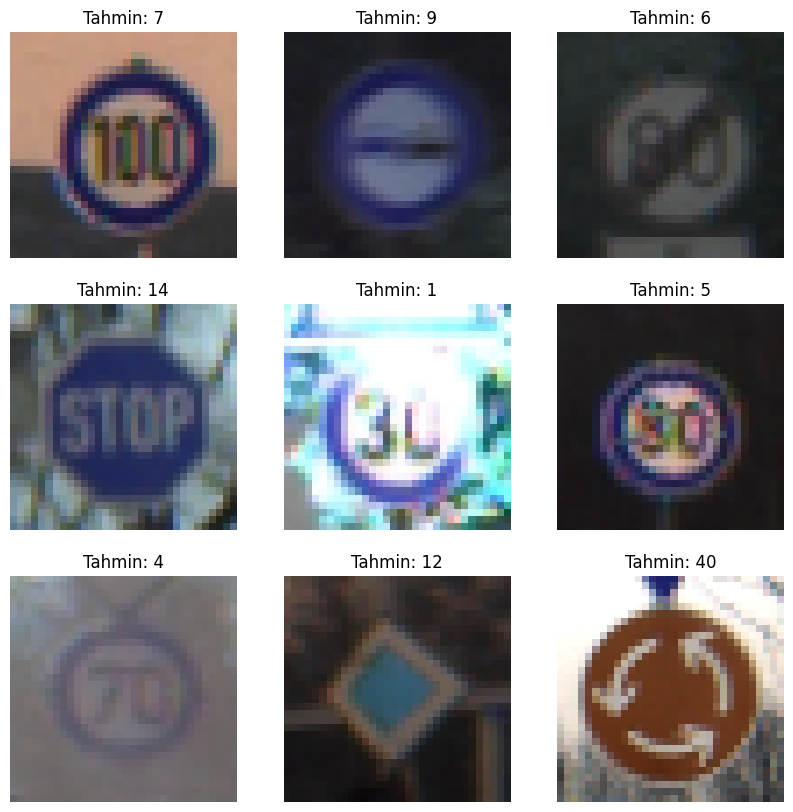

In [12]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Modeli yükle
model = load_model('traffic_sign_model.keras')

# Test görüntüleri üzerinde tahmin yapma
predictions = model.predict(X_test)

# Tahminleri görselleştirme
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i])
    plt.title(f"Tahmin: {np.argmax(predictions[i])}")
    plt.axis('off')
plt.show()

1. Veri Artırma (Data Augmentation)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2
)
model.fit(datagen.flow(X_train, y_train), epochs=10)

2. Daha Derin Model (Örnek: Mini-VGG)


In [14]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

3. Test Seti için Metrikler


In [ ]:
from sklearn.metrics import classification_report

y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))